In [1]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC

np.random.seed(0)

import os
os.add_dll_directory('C:\Aorda\PSG\lib')
import psgpython as psg
from psgutilities import *

In [2]:
def gen_data():
  # Define coordinates for the vertices of the triangle
  vertices = np.array([[-6, 0], [6, 0], [0, 10]])

  # Class -1: Generate data points in the first cluster (triangle vertex 1)
  mean_class_minus = vertices[0]
  cov_class_minus = [[1, 0], [0, 1]]
  class_minus = np.random.multivariate_normal(mean_class_minus, cov_class_minus, 250)

  # Class 0: Generate data points in the second cluster (triangle vertex 2)
  mean_class_zero = vertices[1]
  cov_class_zero = [[1, 0], [0, 1]]
  class_zero = np.random.multivariate_normal(mean_class_zero, cov_class_zero, 250)

  # Class +1: Generate data points in the third cluster (triangle vertex 3)
  mean_class_plus = vertices[2]
  cov_class_plus = [[1, 0], [0, 1]]
  class_plus = np.random.multivariate_normal(mean_class_plus, cov_class_plus, 250)

  # Combine the three clusters and shuffle
  X1 = np.vstack((class_minus, class_zero, class_plus))
  # Assign labels: 0 and 2 as -1, 1 as +1
  y1 = np.where(np.isin(X1, class_minus).all(axis=1) | np.isin(X1, class_plus).all(axis=1), -1, 1)

  # Shuffle the dataset
  shuffle_idx = np.arange(len(X1))
  np.random.shuffle(shuffle_idx)
  X1 = X1[shuffle_idx]
  y1 = y1[shuffle_idx]

  # Create a separate dataset with modified labels
  X2 = np.vstack((class_minus, class_zero, class_plus))
  # Assign labels: 1 and 2 as +1, 0 as -1
  y2 = np.where(np.isin(X2, class_zero).all(axis=1) | np.isin(X2, class_plus).all(axis=1), 1, -1)

  # Shuffle the dataset
  shuffle_idx = np.arange(len(X2))
  np.random.shuffle(shuffle_idx)
  X2 = X2[shuffle_idx]
  y2 = y2[shuffle_idx]

  # Return the datasets
  return [X1, X2], [y1, y2]

In [3]:
def min_bpoe(X, y, a, initial_w=None):
  # multiply each y1 vector a1 scalar (etc. for y2, a2)
  y = [y[i] * a[i] for i in range(DIMS)]
  # Combine X columns into one matrix
  X = np.hstack((X[i] for i in range(DIMS)))
  # add column of 1s to X matrix
  extra_column = np.ones((len(X), DIMS))
  X = np.hstack((X, extra_column))

  # multiply each of the y columns by the respective X columns
  cols_to_multiply1 = X[:, [0, 1, 4]]
  cols_to_multiply2 = X[:, [2, 3, 5]]

  result1 = cols_to_multiply1 * y[0].reshape(-1, 1)
  result2 = cols_to_multiply2 * y[1].reshape(-1, 1)

  bpoe_matrix_scenarios_body = np.hstack((result1, result2))

  # add benchmark column
  bpoe_scenario_benchmark = np.array([a @ x] * len(X))
  bpoe_matrix_scenarios_body = np.column_stack((bpoe_matrix_scenarios_body, bpoe_scenario_benchmark))

  bpoe_header = ['w11', 'w12', 'b1', 'w21', 'w22', 'b2']
  bpoe_matrix_scenarios = [bpoe_header+['scenario_benchmark'], bpoe_matrix_scenarios_body]
  bpoe_matrix_quadratic1_body = np.asarray([[1, 0, 0, 0, 0, 0],
                                            [0, 1, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0]])
  bpoe_matrix_quadratic2_body = np.asarray([[0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 1, 0, 0],
                                            [0, 0, 0, 0, 1, 0],
                                            [0, 0, 0, 0, 0, 0]])
  bpoe_matrix_quadratic1 = [bpoe_header, bpoe_matrix_quadratic1_body]
  bpoe_matrix_quadratic2 = [bpoe_header, bpoe_matrix_quadratic2_body]

  allowExternal = True
  suppressMessages = False
  bpoe_problem_name = "problem_classify"
  bpoe_problem_statement = f"minimize\n\
  bpoe({0},matrix_scenarios)\n\
  Constraint: <= 1\n\
  quadratic(matrix_quadratic1)\n\
  Constraint: <= 1\n\
  quadratic(matrix_quadratic2)\n\
  Box: >= -10, <= 10\n\
  Solver: VAN"
  bpoe_problem_dictionary = {'problem_name':bpoe_problem_name, 
                             'problem_statement':bpoe_problem_statement, 
                             'matrix_scenarios':bpoe_matrix_scenarios, 
                             'matrix_quadratic1':bpoe_matrix_quadratic1, 
                             'matrix_quadratic2':bpoe_matrix_quadratic2}
  # if an initial point estimate is provided use it
  if(initial_w is not None):
    bpoe_problem_statement = f"minimize\n\
    bpoe({0},matrix_scenarios)\n\
    Constraint: <= 1\n\
    quadratic(matrix_quadratic1)\n\
    Constraint: <= 1\n\
    quadratic(matrix_quadratic2)\n\
    Box: >= -10, <= 10\n\
    Solver: VAN, init_point = point_initial_w"
    bpoe_problem_dictionary['point_initial_w'] = [bpoe_header, initial_w]

  bpoe_res = psg.psg_solver(bpoe_problem_dictionary, allowExternal, suppressMessages)
  print(f"{bpoe_problem_name} Result:\n{bpoe_res}")
  print(f"{bpoe_problem_name} Optimal Point:\n{get_optimalpoint(bpoe_res)}")
  print(f"{bpoe_problem_name} Objective:\n{get_objective(bpoe_res)}")

  return (get_optimalpoint(bpoe_res), get_objective(bpoe_res))

In [9]:
def min_pm(X, y, w, initial_a=None):
  # unpack
  w11, w12, b1, w21, w22, b2 = w
  X1, X2 = X
  y1, y2 = y

  # multiply columns of X by their respective w_ij, sum the columns horizontally, and add b_j
  X1[:, 0] *= w11
  X1[:, 1] *= w12
  X1 = np.sum(X1, axis=1) + b1
  X1 = x[0] - (y1 * X1)

  X2[:, 0] *= w21
  X2[:, 1] *= w22
  X2 = np.sum(X2, axis=1) + b2
  X2 = x[1] - (y2 * X2)

  pm_matrix_scenarios_body = np.column_stack((X1, X2))
  pm_header = ['a1', 'a2']
  pm_matrix_scenarios = [pm_header, pm_matrix_scenarios_body]
  pm_matrix_linear_body = np.asarray([1, 1])
  pm_matrix_linear = [pm_header, pm_matrix_linear_body]

  allowExternal = True
  suppressMessages = False
  pm_problem_name = "problem_classify"
  pm_problem_statement = f"minimize\n\
  pm_pen({-1},matrix_scenarios)\n\
  Constraint: == 2\n\
  linear(matrix_linear)\n\
  Box: >= 0\n\
  Solver: CAR"
  pm_problem_dictionary = {'problem_name':pm_problem_name, 
                             'problem_statement':pm_problem_statement, 
                             'matrix_scenarios':pm_matrix_scenarios,
                             'matrix_linear':pm_matrix_linear}
  # if initila point estimate is provided use it
  if(initial_a is not None):
    pm_problem_statement = f"minimize\n\
    pm_pen({-1},matrix_scenarios)\n\
    Constraint: == 2\n\
    variable(a1)\n\
    variable(a2)\n\
    Box: >= 0\n\
    Solver: CAR, init_point = point_initial_a"
    pm_problem_dictionary['point_initial_a'] = [pm_header, initial_a]

  pm_res = psg.psg_solver(pm_problem_dictionary, allowExternal, suppressMessages)
  print(f"{pm_problem_name} Result:\n{pm_res}")
  print(f"{pm_problem_name} Optimal Point:\n{get_optimalpoint(pm_res)}")
  print(f"{pm_problem_name} Objective:\n{get_objective(pm_res)}")

  return (get_optimalpoint(pm_res), get_objective(pm_res))

  

In [5]:
def driver():
  X, y = gen_data()

  # step 2
  bpoe_opt_point, bpoe_obj = min_bpoe(np.copy(X), np.copy(y), a)
  w_tilda = bpoe_opt_point[1]
  # step 3
  pm_opt_point, pm_obj = min_pm(np.copy(X), np.copy(y), w_tilda)
  a_tilda = pm_opt_point[1]

  a1, a2 = a_tilda
  w11, w12, b1, w21, w22, b2 = w_tilda

  p_tilda = pm_obj
  print('p tilda:')
  print(p_tilda)

  w_star = w_tilda
  a_star = a
  while(True):
    bpoe_opt_point, bpoe_obj = min_bpoe(np.copy(X), np.copy(y), a_tilda, initial_w = w_tilda)
    w_star = bpoe_opt_point[1]
    pm_opt_point, pm_obj = min_pm(np.copy(X), np.copy(y), w_star, initial_a = a_tilda)
    a_star = pm_opt_point[1]

    w11, w12, b1, w21, w22, b2 = w_star

    p_star = pm_obj
    print('p star:')
    print(p_star)

    if(p_tilda - p_star < epsilon):
      break
      
    w_tilda, a_tilda, p_tilda = w_star, a_star, p_star
  
  return p_tilda, p_star, w_tilda, w_star, a_tilda, a_star, X, y


In [6]:
# Constants / vectors
DIMS = 2
a = np.array([1] * DIMS) # initial vector
epsilon = 0.001 # error allowance
x = np.array([2] * DIMS)

C:\Users\jacob\AppData\Local\Temp\ipykernel_7888\202200021.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.hstack((X[i] for i in range(DIMS)))


Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.456814028493E+01  Residual=-.800000000000E+01
Ext.iteration=32  Objective=0.156846954139E+01  Residual=-.499792914606E+01
Start stage  1
Ext.iteration=0  Objective=0.200641096633E-13  Residual=-.499792914606E+01
Ext.iteration=49  Objective=-.827966956173E+01  Residual=0.833999536098E-11
Start stage  2
Ext.iteration=0  Objective=0.967270635168E-13  Residual=0.833999536098E-11
Ext.iteration=75  Objective=-.874848607429E+00  Residual=0.302170086286E-06
Start stage  3
Ext.iteration=0  Objective=0.500606034458E-13  Residual=0.302170086286E-06
Ext.iteration=34  Objective=-.219863879576E+00  Residual=0.727040482928E-06
Start stage  4
Ext.iteration=0  Objective=-.380570259126E-13  Residual=0.727040482928E-06
Ext.iteration=48 

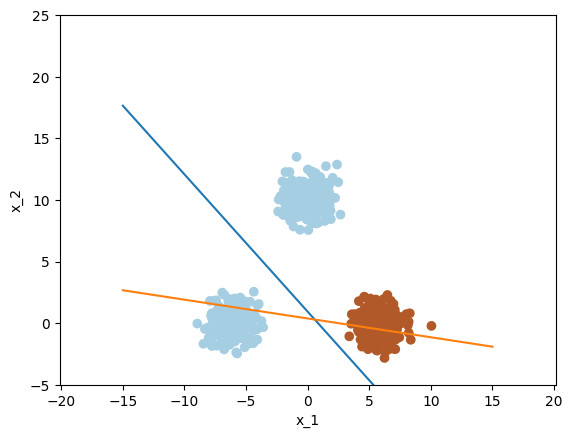

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.458738948900E+01  Residual=-.800000000000E+01
Ext.iteration=26  Objective=0.189675250163E+01  Residual=-.587255405887E+01
Start stage  1
Ext.iteration=0  Objective=0.326134049141E-13  Residual=-.587255405887E+01
Ext.iteration=44  Objective=-.170265186475E+02  Residual=0.100044417195E-10
Start stage  2
Ext.iteration=0  Objective=0.640754842402E-13  Residual=0.100044417195E-10
Ext.iteration=78  Objective=-.734855375776E+00  Residual=0.112745368597E-10
Start stage  3
Ext.iteration=0  Objective=0.106562488081E-12  Residual=0.112745368597E-10
Ext.iteration=53  Objective=-.174778704457E+00  Residual=0.232207369777E-06
Start stage  4
Ext.iteration=0  Objective=0.440946815778E-13  Residual=0.232207369777E-06
Ext.iteration=21  Objective=-.508465338928E-02  Residu

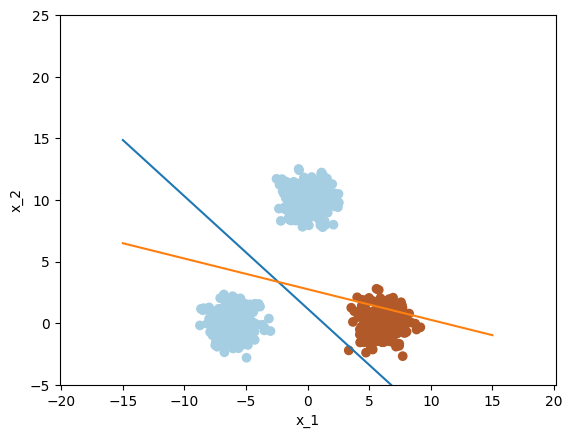

Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.468550285656E+01  Residual=-.800000000000E+01
Ext.iteration=23  Objective=0.195796392082E+01  Residual=-.496879052916E+01
Start stage  1
Ext.iteration=0  Objective=0.356221294813E-13  Residual=-.496879052916E+01
Ext.iteration=46  Objective=-.173641101917E+02  Residual=0.974509362095E-11
Start stage  2
Ext.iteration=0  Objective=0.103642895258E-12  Residual=0.974509362095E-11
Ext.iteration=95  Objective=-.762849898481E+00  Residual=0.871835936778E-11
Start stage  3
Ext.iteration=0  Objective=0.479556011964E-13  Residual=0.871835936778E-11
Ext.iteration=57  Objective=-.151486440859E+00  Residual=0.205534078646E-08
Start stage  4
Ext.iteration=0  Objective=-.604498419045E-13  Residual=0.205534078646E-08
Ext.iteration=32 

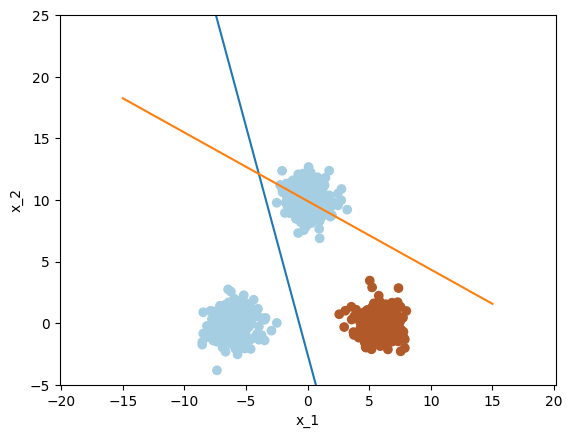

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.482716578932E+01  Residual=-.800000000000E+01
Ext.iteration=24  Objective=0.195308328155E+01  Residual=-.571960721826E+01
Start stage  1
Ext.iteration=0  Objective=0.362297155312E-13  Residual=-.571960721826E+01
Ext.iteration=41  Objective=-.183804070569E+02  Residual=0.136211042445E-10
Start stage  2
Ext.iteration=0  Objective=0.318426244085E-12  Residual=0.136211042445E-10
Ext.iteration=84  Objective=-.426168047229E+00  Residual=0.157225343855E-10
Start stage  3
Ext.iteration=0  Objective=0.156029413188E-12  Residual=0.157225343855E-10
Ext.iteration=59  Objective=-.448373228735E-01  Residual=0.733353068938E-06
Start stage  4
Ext.iteration=0  Objective=0.889356289725E-13  Residual=0.733353068938E-06
Ext.iteration=22  Objective=-.558633500922E-03  Residu

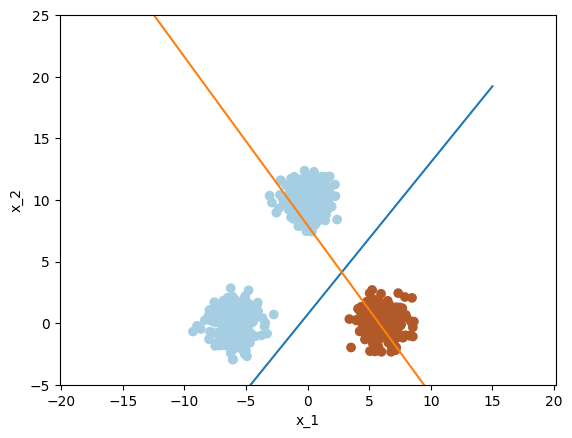

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.439265941542E+01  Residual=-.800000000000E+01
Ext.iteration=44  Objective=0.150486031954E+01  Residual=-.489088678746E+01
Start stage  1
Ext.iteration=0  Objective=0.209859350800E-13  Residual=-.489088678746E+01
Ext.iteration=44  Objective=-.544521402076E+01  Residual=0.121391252605E-08
Start stage  2
Ext.iteration=0  Objective=0.951551224138E-13  Residual=0.121391252605E-08
Ext.iteration=82  Objective=-.979328278496E+00  Residual=0.153512758061E-10
Start stage  3
Ext.iteration=0  Objective=0.743575043180E-13  Residual=0.153512758061E-10
Ext.iteration=59  Objective=-.202837081717E+00  Residual=0.209816615637E-06
Start stage  4
Ext.iteration=0  Objective=0.223217675186E-13  Residual=0.209816615637E-06
Ext.iteration=34  Objective=-.113667139668E-01  Residu

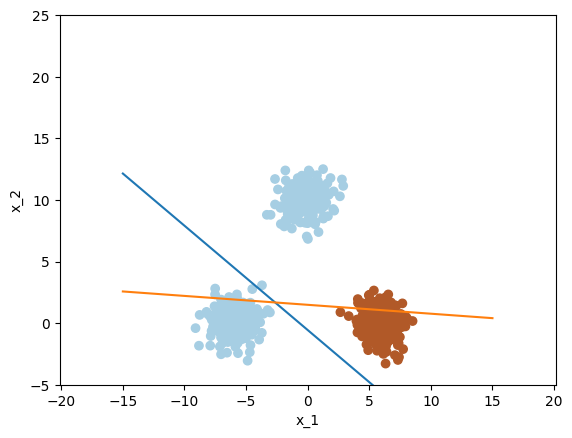

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.487289729801E+01  Residual=-.800000000000E+01
Ext.iteration=39  Objective=0.178712061441E+01  Residual=-.489669626378E+01
Start stage  1
Ext.iteration=0  Objective=0.249589746919E-13  Residual=-.489669626378E+01
Ext.iteration=45  Objective=-.125293599307E+02  Residual=0.110347286864E-10
Start stage  2
Ext.iteration=0  Objective=0.523908525223E-13  Residual=0.110347286864E-10
Ext.iteration=88  Objective=-.836220906584E+00  Residual=0.370211754586E-06
Start stage  3
Ext.iteration=0  Objective=0.808766021478E-14  Residual=0.370211754586E-06
Ext.iteration=57  Objective=-.218570024914E+00  Residual=0.594704196999E-06
Start stage  4
Ext.iteration=0  Objective=-.668684346982E-13  Residual=0.594704196999E-06
Ext.iteration=26  Objective=-.122968997233E-01  Residu

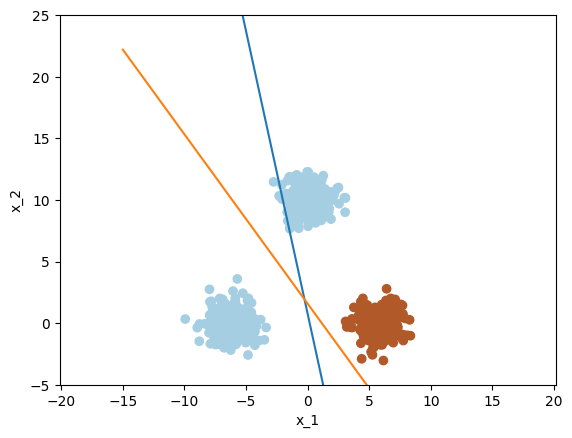

Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.469488565211E+01  Residual=-.800000000000E+01
Ext.iteration=24  Objective=0.185496690936E+01  Residual=-.700008024531E+01
Start stage  1
Ext.iteration=0  Objective=0.337691191191E-13  Residual=-.700008024531E+01
Ext.iteration=35  Objective=-.191330292607E+02  Residual=0.562394575354E-11
Start stage  2
Ext.iteration=0  Objective=0.429544517827E-13  Residual=0.562394575354E-11
Ext.iteration=87  Objective=-.428038236187E+00  Residual=0.193518090441E-08
Start stage  3
Ext.iteration=0  Objective=-.100675917998E-12  Residual=0.193518090441E-08
Ext.iteration=63  Objective=-.764832867356E-01  Residual=0.724905342864E-06
Start stage  4
Ext.iteration=0  Objective=0.737067966462E-13  Residual=0.724905342864E-06
Ext.iteration=45 

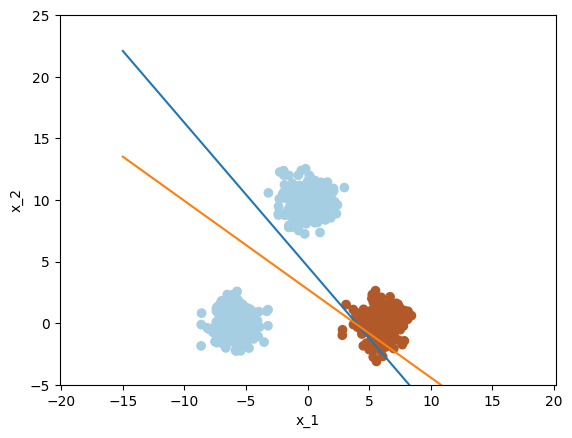

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.451816125009E+01  Residual=-.800000000000E+01
Ext.iteration=33  Objective=0.177282487686E+01  Residual=-.608578908869E+01
Start stage  1
Ext.iteration=0  Objective=0.256237344699E-13  Residual=-.608578908869E+01
Ext.iteration=45  Objective=-.161374076555E+02  Residual=0.103739239421E-10
Start stage  2
Ext.iteration=0  Objective=0.159724234460E-12  Residual=0.103739239421E-10
Ext.iteration=83  Objective=-.667163588479E+00  Residual=0.120135013049E-10
Start stage  3
Ext.iteration=0  Objective=-.103322737842E-12  Residual=0.120135013049E-10
Ext.iteration=57  Objective=-.170640982462E+00  Residual=0.554223333893E-12
Start stage  4
Ext.iteration=0  Objective=0.246840326034E-13  Residual=0.554223333893E-12
Ext.iteration=23  Objective=-.533153703604E-02  Residu

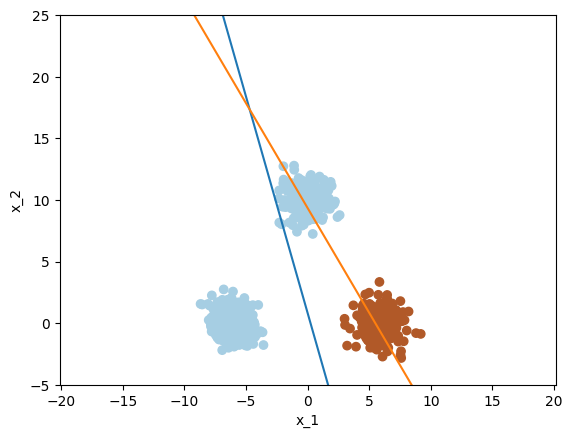

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.464628142756E+01  Residual=-.800000000000E+01
Ext.iteration=34  Objective=0.193991553185E+01  Residual=-.678224446453E+01
Start stage  1
Ext.iteration=0  Objective=0.390280119432E-13  Residual=-.678224446453E+01
Ext.iteration=35  Objective=-.212172427030E+02  Residual=0.106054187654E-08
Start stage  2
Ext.iteration=0  Objective=0.220465111332E-12  Residual=0.106054187654E-08
Ext.iteration=120  Objective=-.133089999485E+00  Residual=0.723154869320E-11
Start stage  3
Ext.iteration=0  Objective=-.497496315472E-13  Residual=0.723154869320E-11
Ext.iteration=99  Objective=-.205236888500E-01  Residual=0.127791111026E-10
Start stage  4
Ext.iteration=0  Objective=-.553088587520E-13  Residual=0.127791111026E-10
Ext.iteration=30  Objective=-.111825718681E-03  Resid

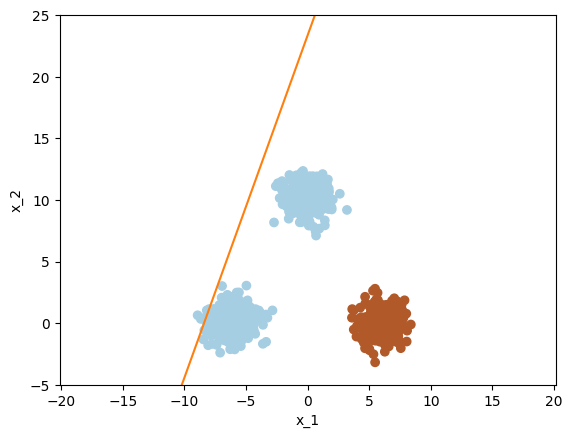

Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.475799627687E+01  Residual=-.800000000000E+01
Ext.iteration=36  Objective=0.185816726070E+01  Residual=-.483219430830E+01
Start stage  1
Ext.iteration=0  Objective=0.261525350690E-13  Residual=-.483219430830E+01
Ext.iteration=48  Objective=-.128293651693E+02  Residual=0.878763728451E-11
Start stage  2
Ext.iteration=0  Objective=0.105470656448E-13  Residual=0.878763728451E-11
Ext.iteration=94  Objective=-.608232349831E+00  Residual=0.752642392854E-11
Start stage  3
Ext.iteration=0  Objective=0.102401908045E-12  Residual=0.752642392854E-11
Ext.iteration=43  Objective=-.145685788210E+00  Residual=0.203738554916E-07
Start stage  4
Ext.iteration=0  Objective=-.516292431728E-13  Residual=0.203738554916E-07
Ext.iteration=42 

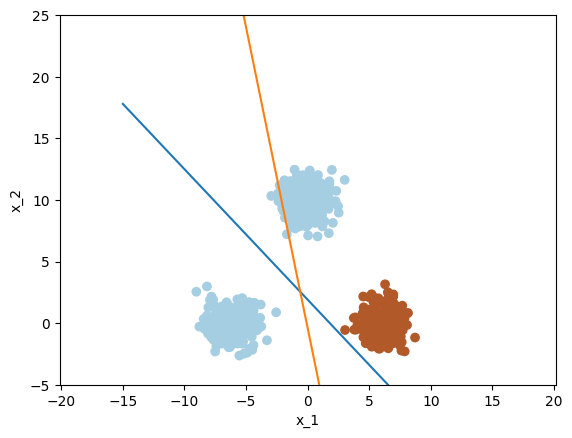

In [10]:
for i in range(10):
  p_tilda, p_star, w_tilda, w_star, a_tilda, a_star, X, y = driver()
  f1 = lambda x: (w_star[2] - w_star[0]*x)/w_star[1]
  f2 = lambda x: (w_star[5] - w_star[3]*x)/w_star[4]
  x_vals = np.linspace(-15, 15, 20)
  y1_vals = f1(x_vals)
  y2_vals = f2(x_vals)
  plt.scatter(X[0][:, 0], X[0][:, 1], c=y[0], cmap=plt.cm.Paired)
  plt.plot(x_vals, y1_vals)
  plt.plot(x_vals, y2_vals)
  plt.xlabel('x_1')
  plt.ylabel('x_2')
  plt.axis('equal')
  plt.xlim(-10, 10)
  plt.ylim(-5, 25)
  plt.show()